In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 10000
#maxEvents = 20000

debug = 1

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(strip_unit=8*2, kernel_size=1, stride=1, verbose=1):
  tree = load_pgun()
  
  outs = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    sector_phi_me1_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_me1_array.shape):
      sector_phi_me1_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      assert(hit.emtf_phi < 5040)  # 84*60
      
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
      
      if (hit.type == kCSC and hit.station == 1) or (hit.type == kME0 and hit.station == 1):
        sector_phi_me1_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    #print "ievt {0} nhits {1}".format(ievt, len(evt.hits))
    #print "..", sector_cnt_array
    #print "..", sector_cnt_array[best_sector]
    #print "..", sector_phi_array[best_sector]
    
    # Find the best phi bin
    phis = sector_phi_array[best_sector]
    phis = np.asarray(phis)
    phis /= strip_unit
    
    phis_me1 = sector_phi_me1_array[best_sector]
    phis_me1 = np.asarray(phis_me1)
    phis_me1 /= strip_unit
    
    bin_counts = np.zeros(((5040/strip_unit)+1,), dtype=np.int32)
    bin_counts_me1 = np.zeros(((5040/strip_unit)+1,), dtype=np.int32)
    for i in xrange(0,(5040/strip_unit)+1, stride):
      d = (kernel_size-1)/2
      a = i-d
      b = a + (kernel_size-1)
      bin_counts[i] = np.sum((a <= phis) & (phis <= b))
      bin_counts_me1[i] = np.sum((a <= phis_me1) & (phis_me1 <= b))

    best_bin = np.argmax(bin_counts)
    bin_cnt = bin_counts[best_bin]
    bin_cnt_me1 = bin_counts_me1[best_bin]
    delta = np.max(phis) - np.min(phis)
    
    # Debug
    if debug and verbose and ievt < 20:
      print ievt, part.pt, len(phis), bin_cnt, bin_cnt_me1, delta
    
    outs.append((part.pt, len(phis), bin_cnt, bin_cnt_me1, delta))

  return np.asarray(outs)

In [5]:
#eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30.)
edges = np.asarray(eff_pt_bins)

def post_analysis(outs):
  xdata = (edges[1:] + edges[:-1])/2

  denom = np.zeros_like(xdata, dtype=np.float32)
  numer = np.zeros_like(xdata, dtype=np.float32)

  for o in outs:
    (pt, cnt, bin_cnt, bin_cnt_me1, delta) = o
    x = np.digitize(pt, bins=eff_pt_bins[1:])  # skip lowest edge
    if x == len(xdata):
      x -= 1
    denom[x] += 1
    if bin_cnt >= 3 and bin_cnt_me1 >= 1 and bin_cnt >= (0.6*cnt):
      numer[x] += 1
    #elif pt > 20:
    #  print (pt, cnt, bin_cnt, bin_cnt_me1, delta)

  denom[denom == 0] = 1
  ydata = np.true_divide(numer, denom)
  return xdata, ydata

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 8 5 0 3
2 2.83313345909 8 6 0 2
3 2.32413506508 5 2 0 5
4 6.14469432831 9 9 2 1
5 5.51849126816 9 9 1 1
6 2.62028098106 10 6 0 2
7 6.84316205978 9 8 1 2
8 2.37840628624 11 6 0 6
9 2.898209095 8 5 0 4
10 2.72461438179 8 6 0 4
11 3.73449015617 10 7 0 2
12 52.140007019 8 8 2 1
14 8.361577034 6 6 1 1
15 7.21895551682 10 9 1 2
16 25.9081859589 9 9 2 0
17 2.27322983742 9 5 0 4
18 16.2746582031 8 8 1 1
19 10.1214160919 7 7 1 1
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000


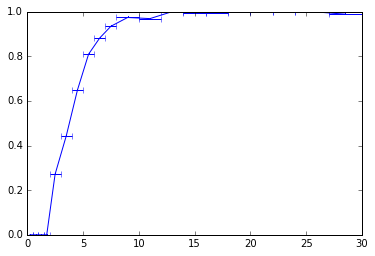

Using strip_unit=128 kernel_size=2 stride=1
[[ 2.24410081  8.          5.          0.          3.        ]
 [ 2.83313346  8.          6.          0.          2.        ]
 [ 2.32413507  5.          2.          0.          5.        ]
 ...
 [ 2.24172401  6.          6.          1.          1.        ]
 [31.09728622  7.          7.          2.          1.        ]
 [32.35217667  7.          7.          2.          0.        ]]
[ 0.25  0.75  1.25  1.75  2.5   3.5   4.5   5.5   6.5   7.5   9.   11.
 13.   15.   17.   19.   21.   23.   25.5  28.5 ] [0.         0.         0.         0.         0.27138984 0.44328552
 0.6481481  0.80937    0.88185656 0.9343284  0.97363085 0.968652
 1.         0.99415207 0.99236643 1.         1.         1.
 1.         0.9883721 ]


In [6]:
# Run analysis

strip_unit = 8*16
kernel_size = 2
stride = 1
outs = analysis(strip_unit=strip_unit, kernel_size=kernel_size, stride=stride)
xdata, ydata = post_analysis(outs)
xerr = (edges[1:] - edges[:-1])/2

plt.figure()
plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)
plt.show()

print "Using strip_unit={0} kernel_size={1} stride={2}".format(strip_unit, kernel_size, stride)
print outs
print xdata, ydata

In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

Using strip_unit=16 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=32 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=64 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=128 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=256 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=315 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=420 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=630 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=1260 kernel_size=2 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6

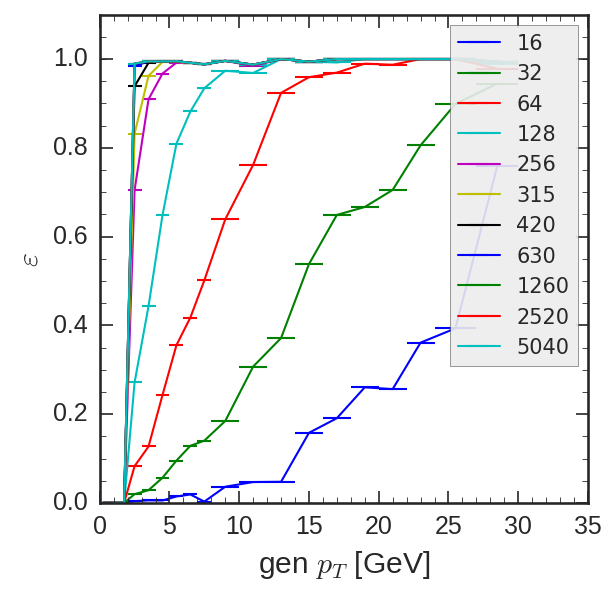

In [8]:
# Run more analysis

if True:
  plt.figure()

  strip_units = [8*2, 8*4, 8*8, 8*16, 8*32, 5040/16, 5040/12, 5040/8, 5040/4, 5040/2, 5040]

  for strip_unit in strip_units:
    print "Using strip_unit={0} kernel_size={1} stride={2}".format(strip_unit, kernel_size, stride)
    outs = analysis(strip_unit=strip_unit, kernel_size=kernel_size, stride=stride, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(strip_units, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()

Using strip_unit=16 kernel_size=3 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=5 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=7 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=9 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=11 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=15 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=20 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=30 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root


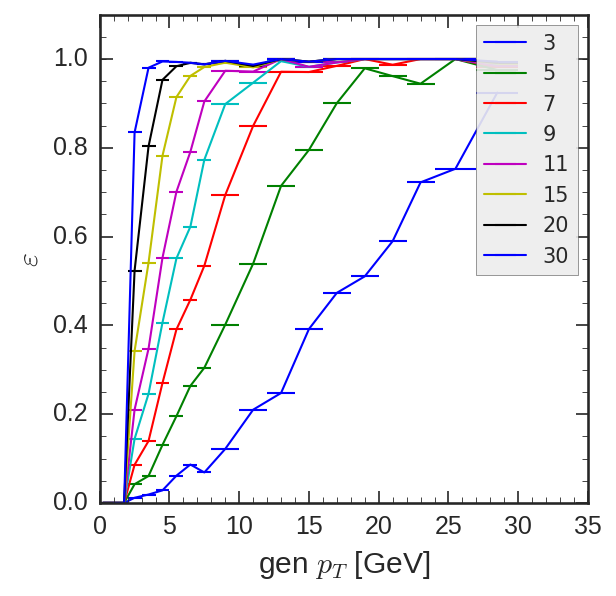

In [9]:
# Run more analysis

if True:
  plt.figure()

  strip_unit = 8*2
  kernel_sizes = [3,5,7,9,11,15,20,30,]

  for kernel_size in kernel_sizes:
    print "Using strip_unit={0} kernel_size={1} stride={2}".format(strip_unit, kernel_size, stride)
    outs = analysis(strip_unit=strip_unit, kernel_size=kernel_size, stride=stride, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(kernel_sizes, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()

Using strip_unit=16 kernel_size=9 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=9 stride=2
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=9 stride=3
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=9 stride=4
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root


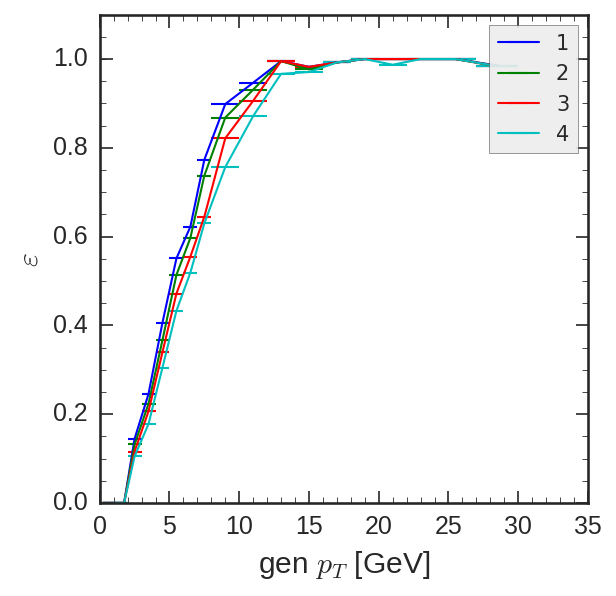

In [10]:
# Run more analysis

if True:
  plt.figure()

  strip_unit = 8*2
  kernel_size = 9
  strides = [1,2,3,4]

  for stride in strides:
    print "Using strip_unit={0} kernel_size={1} stride={2}".format(strip_unit, kernel_size, stride)
    outs = analysis(strip_unit=strip_unit, kernel_size=kernel_size, stride=stride, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(strides, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()

Using strip_unit=16 kernel_size=19 stride=1
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=19 stride=2
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=19 stride=3
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=19 stride=4
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit=16 kernel_size=19 stride=5
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root


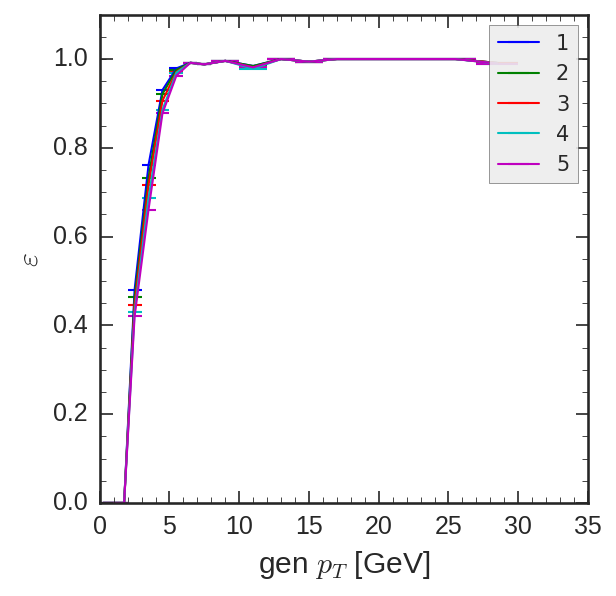

In [11]:
# Run more analysis

if True:
  plt.figure()

  strip_unit = 8*2
  kernel_size = 19
  strides = [1,2,3,4,5]

  for stride in strides:
    print "Using strip_unit={0} kernel_size={1} stride={2}".format(strip_unit, kernel_size, stride)
    outs = analysis(strip_unit=strip_unit, kernel_size=kernel_size, stride=stride, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(strides, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()